# Language Classification with Naive Bayes in Python

## Recommended Prerequisites for Successful Completion
* Intermediate level understanding of Python 3+ (e.g. list and dictionary comprehension)
* Basics of machine learning (e.g. the distinction between training and validation data)
* Mathematical probability (e.g. understanding Bayes' Theorem at a basic level)


## Project Outline
Introduction (#intro)

(#task1): Exploratory Data Analysis + Visualization

(#task2): Data Cleaning and Preprocessing

(#task3): Naive Bayes Model Introduction and Training

(#task4): Highlighting Problems with Basic Model and Simple Fixes

(#task5): Advanced Approach to Further Improve Performance

In [24]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from tqdm import tqdm_notebook
import numpy as np
import string

from collections import defaultdict

from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

import joblib
import pickle as pkl
from sklearn.metrics import confusion_matrix
import seaborn as sns


<a id='intro'></a>
# Introduction

## [Slovak Wikipedia Entry](https://sk.wikipedia.org/wiki/Jazveč%C3%ADk)
Mnohí ľudia, ktorí vidia na ulici jazvečíka s podlhovastým telom vôbec nevedia o tom, že tento malý štvornohý a veľmi obľúbený spoločník je pri dobrom výcviku obratným, vynikajúcim a spoľahlivým poľovným psom. Ako poľovný pes je mnohostranne využiteľný, okrem iného ako durič na brlohárenie. Králičí jazvečík sa dokáže obratne pohybovať v králičej nore. S inými psami a deťmi si nie vždy rozumie.

## [Czech Wikipedia Entry](https://cs.wikipedia.org/wiki/Jezevč%C3%ADk)
Úplně první zmínky o psech podobných dnešním jezevčíkům nacházíme až ve Starém Egyptě, kde jsou vyobrazeni na soškách a rytinách krátkonozí psi s dlouhým hřbetem a krátkou srstí. Jednalo se ale o neustálený typ bez ustáleného jména. Další zmínky o jezevčících nacházíme až ve 14 - 15. století. Jedná se o psa, který se nejvíce podobá dnešnímu typu hladkosrstého standardního jezevčíka.


## [English Wikipedia Entry](https://en.wikipedia.org/wiki/Dachshund)
While classified in the hound group or scent hound group in the United States and Great Britain, the breed has its own group in the countries which belong to the Fédération Cynologique Internationale (World Canine Federation). Many dachshunds, especially the wire-haired subtype, may exhibit behavior and appearance that are similar to that of the terrier group of dogs.

<a id='task1'></a>
# Task 1: Data Exploration and Visualization

In [5]:
def open_file(filename):
    with open(filename, encoding="utf8") as f:
        data = f.readlines()
    return data

In [6]:
data_raw = dict()
data_raw['sk'] = open_file('Data/Sentences/train_sentences.sk')
data_raw['cs'] = open_file('Data/Sentences/train_sentences.cs')
data_raw['en'] = open_file('Data/Sentences/train_sentences.en')

In [7]:
def show_statistics(data):
    for language, sentences in data.items():
        
        number_of_sentences = 0
        number_of_words = 0
        number_of_unique_words = 0
        sample_extract = ''
        
        # take a few minutes to try populate these variables
        
        # here is a hint -- word_list breaks the collections of sentences into a list of words
        word_list = ' '.join(sentences).split()
        
        
        print(f'Language: {language}')
        print('-----------------------')
        print(f'Number of sentences\t:\t {number_of_sentences}')
        print(f'Number of words\t\t:\t {number_of_words}')
        print(f'Number of unique words\t:\t {number_of_unique_words}')
        print(f'Sample extract\t\t:\t {sample_extract}...\n')

In [8]:
show_statistics(data_raw)

Language: sk
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: cs
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: en
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...



<a id='task2'></a>
# Task 2: Data Cleaning and Preprocessing

In [9]:
def preprocess(text):
    '''
    Removes punctuation and digits from a string, and converts all characters to lowercase. 
    Also clears all \n and hyphens (splits hyphenated words into two words).
    
    '''
        
    preprocessed_text = text.lower().replace('-', ' ')
    
    translation_table = str.maketrans('\n', ' ', string.punctuation+string.digits)
    
    preprocessed_text = preprocessed_text.translate(translation_table)
        
    return preprocessed_text

In [10]:
data_preprocessed = {k: [preprocess(sentence) for sentence in v] for k, v in data_raw.items()}

In [11]:
show_statistics(data_preprocessed)

Language: sk
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: cs
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: en
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...



<a id='task3'></a>
# Task 3: The Naive Bayes Model

**Bayes' Theorem**

\begin{equation}
P(A | B)=\frac{P(B | A) \times P(A)}{P(B)}
\end{equation}

Now, let's translate this theory into our specific problem. In our case, where we want to categorise a sentence `my name is Ari` into one of `sk`, `cs`, or `en`, the following are the probabilities we want to determine.

\begin{equation}
P(\text {sk} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {sk}) \times P(\text {sk})}{P(\text {my name is Ari})}
\end{equation}

\begin{equation}
P(\text {cs} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {cs}) \times P(\text {cs})}{P(\text {my name is Ari})}
\end{equation}

\begin{equation}
P(\text {en} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {en}) \times P(\text {en})}{P(\text {my name is Ari})}
\end{equation}

## Unseen Data

Since we assume conditional independence across our features, our numerator term for any of the above equations can be broken into the following.

\begin{equation}
P(\text {my name is Ari} | \text {en}) = P(\text {my} | \text {en}) \times P(\text {name} | \text {en}) \times P(\text {is} | \text {en}) \times P(\text {Ari} | \text {en})
\end{equation}

## Vectorizing Training Data

In [12]:
def get_data(data):
    st , label = [],[]
    for k, v in data.items():
        for sentences in v:
            st.append(sentences)
            label.append(k)
    return st, label

In [13]:
sentences_train, y_train = get_data(data_preprocessed)


In [14]:
vectorizer = CountVectorizer()

In [15]:
X_train = vectorizer.fit_transform(sentences_train)

In [16]:
X_train

<210x2208 sparse matrix of type '<class 'numpy.int64'>'
	with 3867 stored elements in Compressed Sparse Row format>

## Initializing Model Parameters and Training

In [17]:
naive_classifier = MultinomialNB()
naive_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Vectorizing Validation Data and Evaluating Model

In [18]:
data_val = dict()
data_val['sk'] = open_file('Data/Sentences/val_sentences.sk')
data_val['cs'] = open_file('Data/Sentences/val_sentences.cs')
data_val['en'] = open_file('Data/Sentences/val_sentences.en')

data_val_preprocessed = {k: [preprocess(sentence) for sentence in v] for k, v in data_val.items()}

In [19]:
sentences_val, y_val = get_data(data_val_preprocessed)

In [20]:
X_val = vectorizer.transform(sentences_val)

In [21]:
predictions = naive_classifier.predict(X_val)

In [29]:

def plot_confusion_matrix(labels , y_pred,classes):
    cm=confusion_matrix(labels,y_pred,classes)
    
    # ploting the matrix in form of heat map

    sns.heatmap(cm)

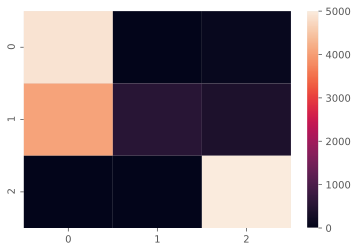

In [30]:
plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])

In [31]:
f1_score(y_val, predictions, average='weighted')

0.6149824401040264


# Simple Adjustments and Highlighting Model Shortcomings

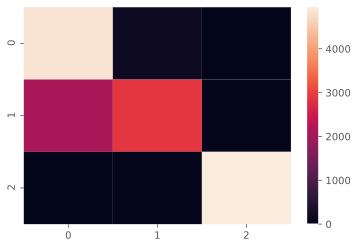

In [32]:
naive_classifier = MultinomialNB(alpha=0.0001, fit_prior=False)
naive_classifier.fit(X_train, y_train)

predictions = naive_classifier.predict(X_val)

plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])

In [33]:
f1_score(y_val, predictions, average='weighted')

0.8368507601649364


# Using Subwords to Shift Perspective

**Dummy Dataset**

playing ; eating ; play ; reads ; tea

**Step 1**

Break each word into characters

playing > p l a y i n g


**Step 2**

Find common character sequences

ea, ing, play

**Step 3**

Convert dataset using these subwords into

play ing ; ea t ing ; play ; r ea d s ; t ea

In [34]:
# taken from https://arxiv.org/abs/1508.07909

import re, collections
def get_stats(vocab):
    pairs = collections.defaultdict(int) 
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq 
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word] 
    return v_out

In [35]:
def get_vocab(data):

    words = []
    for sentence in data:
        words.extend(sentence.split())
        
    vocab = defaultdict(int)
    for word in words:
        vocab[' '.join(word)] += 1
        
    return vocab

In [36]:
vocab = get_vocab(sentences_train)

In [37]:
# also taken from original paper
for i in range(100):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get) 
    vocab = merge_vocab(best, vocab)

In [38]:
merges = defaultdict(int)
for k, v in vocab.items():
    for subword in k.split():
        if len(subword) >= 2:
            merges[subword] += v

In [39]:
merge_ordered = sorted(merges, key=merges.get, reverse=True)

In [40]:
pkl.dump(merge_ordered, open('Data/Auxiliary/merge_ordered.pkl', 'wb'))

In [41]:
def split_into_subwords(text):
    merges = pkl.load(open('Data/Auxiliary/merge_ordered.pkl', 'rb'))
    subwords = []
    for word in text.split():
        for subword in merges:
            subword_count = word.count(subword)
            if subword_count > 0:
                word = word.replace(subword, ' ')
                subwords.extend([subword]*subword_count)
    return ' '.join(subwords)

In [42]:
split_into_subwords('this is ari here')

'is th is ar re'

In [43]:
data_preprocessed_subwords = {k: [split_into_subwords(sentence) for sentence in v] for k, v in data_preprocessed.items()}

In [44]:
show_statistics(data_preprocessed_subwords)

Language: sk
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: cs
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: en
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...



In [45]:
data_train_subwords = []
for sentence in sentences_train:
    data_train_subwords.append(split_into_subwords(sentence))

In [46]:
data_val_subwords = []
for sentence in sentences_val:
    data_val_subwords.append(split_into_subwords(sentence))

In [47]:
vectorizer = CountVectorizer()

In [48]:
X_train = vectorizer.fit_transform(data_train_subwords)
X_val = vectorizer.transform(data_val_subwords)

In [49]:
naive_classifier = MultinomialNB(fit_prior=False)
naive_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

In [50]:
predictions = naive_classifier.predict(X_val)

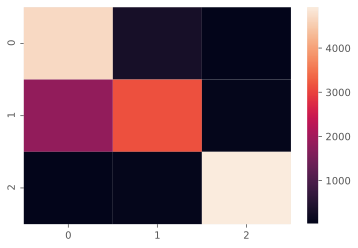

In [51]:
plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])

In [52]:
f1_score(y_val, predictions, average='weighted')

0.8456381060126386